# Feature Analysis 
Here I will train a sci-kit learn RandomForestRegressor on our events training dataset and evaluate two aspects of the model: feature importances and feature ablation. 

In [1]:
# Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Bring in training and validation data 
training_data = pd.read_parquet('assets/training_set_v2.parquet')
validation_data = pd.read_parquet('assets/validation_set_v2.parquet')

### Standardize data and train model

In [2]:
# Drop unwanted columns
columns_to_drop = ['ItemKey', 'RWB_EFFECTIVE_DATE']
X_train = training_data.drop(columns=['events'] + columns_to_drop, axis=1)
X_val = validation_data.drop(columns=['events'] + columns_to_drop, axis=1)

# Scale the data 
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Train random forest model
model = RandomForestRegressor()
model.fit(X_train_std, training_data['events'])

# Get top 10 feature importances from sklearn .featureimportances attribute
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
features_outfeat = [X_train.columns[idx] for idx in sorted_indices]
importance_outfeat = [feature_importances[idx] for idx in sorted_indices]
import_feat_df = pd.DataFrame({"Feature": features_outfeat, "Value": importance_outfeat})

### Evaluate feature importance from the `.feature_importances_` method in sklearn

In [3]:
import plotly.express as px

def create_feat_import_bar_chart(data_frame, x_column, y_column, title="Bar Chart"):
    """
    Create a bar chart using Plotly Express.
    """
    sorted_df = data_frame.sort_values(by=y_column, ascending=True)
    fig = px.bar(data_frame, x=x_column, y=y_column, title=title)
    return fig

# Call the function to create the bar chart
bar_chart = create_feat_import_bar_chart(import_feat_df, 
                                         x_column='Value',
                                          y_column='Feature', 
                                          title='Top 10 Feature Importances from RandomForestRegressor')

# Show the chart
bar_chart.show()

### Perform feature ablation analysis 

In [ ]:
from sklearn.model_selection import cross_val_score

def peform_feature_ablation(model, X_train, X_train_std):

    # Get the features and feature importances from the 
    # first model run in ascending order
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)
    features_outfeat = [X_train.columns[idx] for idx in sorted_indices]

    # Declare a list of all features 
    train_features = list(X_train.columns)

    mae_scores = []
    num_features = []

    # Train a model with all feautures and assess via cross validation 
    mae_cv = -np.mean(cross_val_score(RandomForestRegressor(), 
                                      X_train_std, 
                                      X_train['events'],
                                      scoring='neg_mean_absolute_error',
                                        cv=5))
    
    mae_scores.append(mae_cv)
    num_features.append(len(train_features))

    # Starting with the lowest feature importance, 
    # remove the feature and assess results via cross validation
    for i, feature in enumerate(features_outfeat):

        # remove the feature from the data 
        remove_ind = train_features.index(feature)
        train_features.remove(feature)

        # Use array slicing and indexing to remove the specified column
        X_train_std = np.delete(X_train_std, remove_ind, axis=1)
        
        # Train a model with all feautures and assess via cross validation 
        mae_cv = -np.mean(cross_val_score(RandomForestRegressor(), 
                                        X_train_std, 
                                        X_train['events'],
                                        scoring='neg_mean_absolute_error',
                                            cv=5))
        
        print(f'completed cross val for {i+1} run(s) of feature ablation')
        
        mae_scores.append(mae_cv)
        num_features.append(len(train_features))

        if len(train_features) == 10:
            break

    ablation_results = pd.DataFrame({"Number_of_Features": num_features,
                                     "CV_MAE": mae_scores})
        
    return ablation_results

abla_df = peform_feature_ablation(model, training_data, X_train_std)
abla_df.to_excel('assets/ablation_results.xlsx', index= False)

In [48]:

import plotly.graph_objects as go

def visualize_ablation_results(in_df, baseline):

    in_df['diff_mae'] = in_df['CV_MAE'] - baseline

    fig = px.line(in_df, x='Number_of_Features', y='diff_mae')
    fig.update_xaxes(title_text='Number of Features')
    fig.update_yaxes(title_text='Change in Baseline Average WMAE')
    fig.update_traces(line=dict(color='blue', width=0.9))
    
    # Adding a horizontal dashed line at y=0
    fig.add_shape(
        type="line",
        x0=in_df['Number_of_Features'].min(),
        x1=in_df['Number_of_Features'].max(),
        y0=0,
        y1=0,
        line=dict(color="orange", width=5, dash="dash"),
    )

    # Customize layout
    fig.update_layout(
        template='simple_white', # Set background color to white
          xaxis=dict(
            showgrid=False,  # Turn off x-axis gridlines
            tickvals=[10, 20, 30, 40, 50, 60, 70, 80, 90],    # Set tick value at x=10
        ), 
        height=400,  # Set the height of the graph
        width=600,
    )
    
    # Adding the annotation
    fig.add_annotation(
        text="Baseline Average WMAE = 1.33",
        xref="paper", yref="y",
        x=1, y=0.005,  # Adjust the y value as needed
        showarrow=False,
        font=dict(size=14),
    )
    
    return fig

baseline = 1.355545
fig = visualize_ablation_results(abla_df, baseline)
fig.show()


### Retrain model on top 10 features, get SHAP feature importances 
! warning ! this takes ~9 hours to run.

In [2]:
selected_features =  [
    'Days Since Creation',
    'avg_software_age',
    'FreeSpace_GB',
    'Outlookx86_addin_filesize',
    'Wordx64_addin_filesize',
    'Days Since Last Logon',
    'num_installed_programs',
    'Outlookx64_addin_filesize',
    'InstallAge',
    'LastBootAge',
    'Excelx86_addin_filesize',
    'has_cap_iq_add'
]

final_model = {'bootstrap': False,
 'max_depth': 250,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 450}

In [3]:
# Drop unwanted columns
columns_to_drop = ['ItemKey', 'RWB_EFFECTIVE_DATE']
X_train = training_data.drop(columns=['events'] + columns_to_drop, axis=1)
X_train = X_train[selected_features]
X_val = validation_data.drop(columns=['events'] + columns_to_drop, axis=1)
X_val = X_val[selected_features]

# Scale the data 
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Train random forest model
model = RandomForestRegressor(**final_model)
model.fit(X_train_std, training_data['events'])

RandomForestRegressor(bootstrap=False, max_depth=250, max_features='log2',
                      min_samples_leaf=5, n_estimators=450)

### What is the MAE and RMSE of the model trained on only the top 12 features?

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions_test = model.predict(X_val_std)

# Round predictions (can't have 0.5 number of incidents)
predictions_test = np.round(predictions_test)

mse_test = mean_squared_error(validation_data['events'], predictions_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(validation_data['events'], predictions_test)
print(f'RMSE: {rmse_test} \n MAE: {mae_test}')

RMSE: 1.472632329150987 
 MAE: 1.098899897207095


In [5]:
# Read numpy file
shap_values = np.load('assets/SHAP_values_run2.npy')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


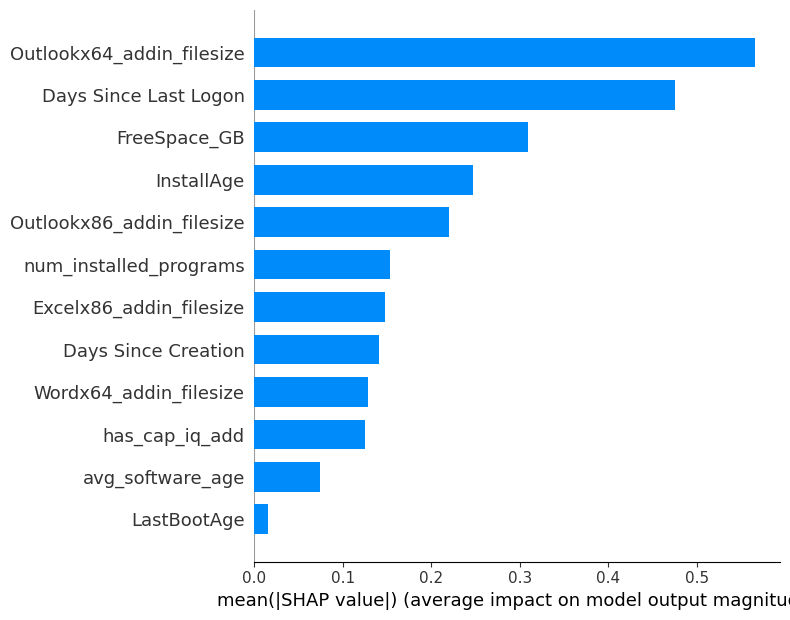

In [6]:
import shap
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train) # started at 7:30 PM CST 7/13
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


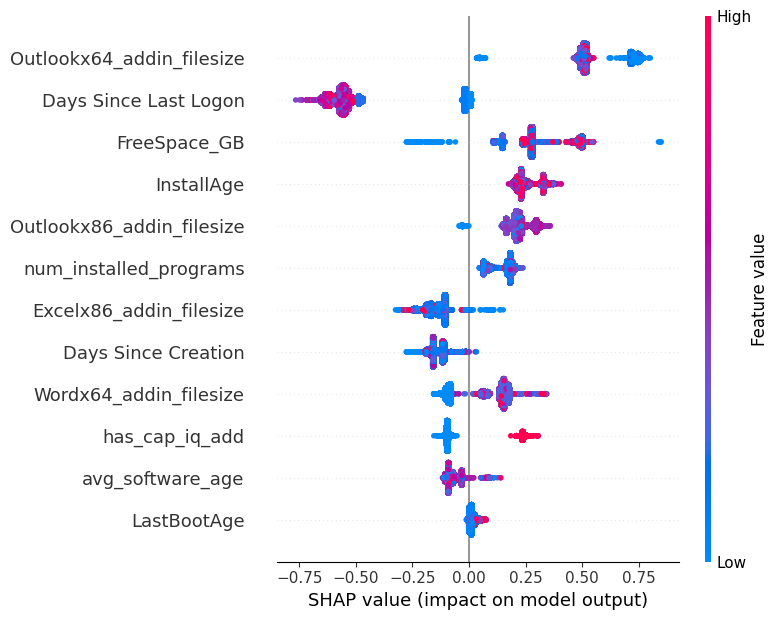

In [7]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

### Assess prediction and error contribution
Adapted from the following article: 
https://medium.com/towards-data-science/your-features-are-important-it-doesnt-mean-they-are-good-ff468ae2e3d4

In [8]:
# Get the training predictions 
y_train_preds = model.predict(X_train_std)

# Get the prediction contribution - PUT THIS IN A DATAFRAME 
y_pred_wo_feature = shap_values.apply(lambda feature: y_train_preds - feature)
abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (training_data['events'] - feature).abs())

# Get the absolute error 
abs_error = np.abs(training_data['events'] - y_train_preds)

# # Get the error contribution
# error_diff = abs_error_wo_feature.apply(lambda feature: abs_error - feature)
# error_contribution = error_diff.mean()

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [12]:
print(X_train.columns)

Index(['Days Since Creation', 'avg_software_age', 'FreeSpace_GB',
       'Outlookx86_addin_filesize', 'Wordx64_addin_filesize',
       'Days Since Last Logon', 'num_installed_programs',
       'Outlookx64_addin_filesize', 'InstallAge', 'LastBootAge',
       'Excelx86_addin_filesize', 'has_cap_iq_add'],
      dtype='object')


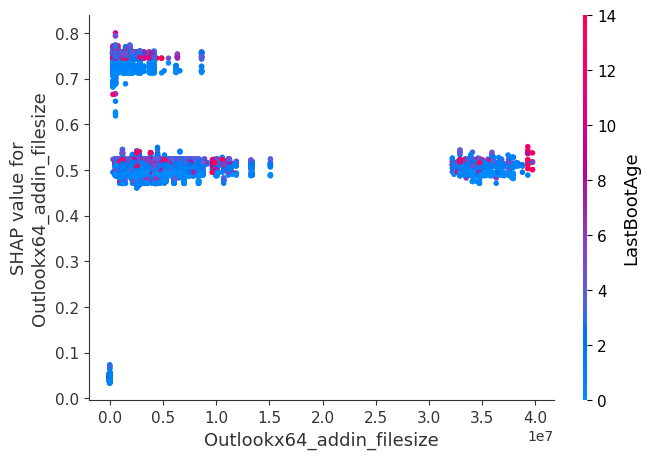

In [11]:
shap.dependence_plot("Outlookx64_addin_filesize", shap_values, X_train)

## What is the weighted MAE score for the training set?

In [14]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

# Define the custom scoring function
def weighted_mae_fun(y_true, y_pred):
    errors = np.abs(y_true - y_pred)

    # Errors for 0 num events are 0.5 times as important 
    # Errors for 1 num events are 1 times as important 
    # Errors for 2 or more num events are 3 times as important 
    sample_weights = np.where(y_true == 0, 0.5, np.where(y_true == 1, 1, 3)) 
    weighted_errors = sample_weights * errors
    weighted_mae_score = np.sum(weighted_errors) / np.sum(sample_weights)
    return np.mean(weighted_mae_score)

# Create a scorer using the custom scoring function
scorer = make_scorer(weighted_mae_fun, greater_is_better=False, needs_proba=False)


# Perform cross-validation
scores = cross_val_score(model, X_train_std, training_data['events'], cv=5, scoring=scorer)

# Display the cross-validation results
print(f"Mean weighted MAE score: ", np.mean(-scores))  # Convert back to positive values

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def eval_predictions3(in_model, pred_df):

    pred_df = pred_df.sort_values('True')

    pred_df['indx'] = [val for val in list(range(len(pred_df)))]

    # Create scatter plot
    fig = px.scatter(pred_df, x='True', y='Predictions', title='Actual vs. Predicted',
                 labels={'True': 'Actual Values', 'Predictions': 'Predicted Values'},
                 hover_name=pred_df.index)
    
    # Add line of equality
    fig.add_shape(type='line', line=dict(dash='dash'), x0=pred_df['True'].min(), x1=pred_df['True'].max(),
                y0=pred_df['True'].min(), y1=pred_df['True'].max())
    
    # Update layout
    fig.update_layout(showlegend=False)

    return fig

# Predict training set values 
predictions_train = model.predict(X_train_std)

# Visualize results 
pred_df = pd.DataFrame({"True": training_data['events'], "Predictions": predictions_train})
eval_predictions3(pred_df)